In [1]:
import matplotlib
matplotlib.use('Agg')

% matplotlib inline

# homebrewed modules
from metro import multiplex as mx
from metro import io            # for reading multiplex
from metro import utility       # for manipulating multiplex
from metro import analysis      # analytical functions
from metro import viz           # for bubble_plot()
from metro import assignment    # for reading and manipulating OD data
from metro import ita

# other modules
import warnings                 # suppress ipython warnings
import networkx as nx           # assigning attributes to multiplex
import random                   # randomly sample node subsets
import matplotlib.pyplot as plt # convenience for plotting

from matplotlib import pylab    # for colormap manipulation
import numpy as np              # math functions
import igraph
import pandas as pd
import matplotlib.cm as cm
import copy


In [2]:
multi = mx.read_multi(nodes_file_name = '3_throughput/mx_flow_nodes.txt', 
                      edges_file_name = '3_throughput/mx_flow_edges.txt')

multi.read_od(layer = 'taz', # keys are in this layer
          key = 'taz', # this is the key attribute
          od_file = '1_data/taz_od/0_1.txt', # here's where the file lives
          sep = ' ') # this is what separates entries

In [3]:
multi.summary()

OD: loaded

layer           	nodes 	edges
----------------------------------------
metro--streets   	0 	234
taz              	4243 	0
streets          	10728 	21508
taz--streets     	0 	8486
metro            	117 	250


In [4]:
len(multi.G.nodes()), len(multi.G.edges())

(15088, 30478)

In [5]:
o_demand = {key : sum(multi.od[key].values()) for key in multi.od}
nx.set_node_attributes(multi.G, 'o_demand', 0)
nx.set_node_attributes(multi.G, 'o_demand', o_demand)

In [6]:
M = multi.layers_as_subgraph(['metro'])
S = multi.layers_as_subgraph(['streets'])
T = multi.layers_as_subgraph(['taz'])

S_M = multi.layers_as_subgraph(['metro', 'streets'])
rm_edges = [e for e in S_M.edges_iter() if S_M.edge[e[0]][e[1]]['layer'] != 'metro--streets']
S_M.remove_edges_from(rm_edges)

S_T = multi.layers_as_subgraph(['taz', 'streets'])
rm_edges = [e for e in S_T.edges_iter() if S_T.edge[e[0]][e[1]]['layer'] != 'taz--streets']
S_T.remove_edges_from(rm_edges)

rm_nodes = [n for n in S_M.nodes() if len(S_M.predecessors(n)) + len(S_M.successors(n)) == 0]
S_M.remove_nodes_from(rm_nodes)
# S_M = multi.layers_as_subgraph(['metro--streets'])
# S_T = multi.layers_as_subgraph(['taz--streets'])


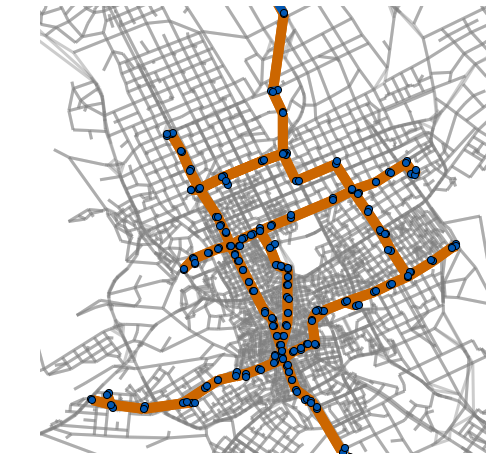

In [7]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111)


center_point = (46.6967, 24.6933)
# l = .02
l = .2

xlim = (center_point[0] - l, center_point[0] + l)
ylim = (center_point[1] - l + .05, center_point[1] + l + .05)

ax.set(xlim = xlim, ylim = ylim)

nx.draw(S,
        viz.get_coords(S),
        edge_color = 'grey', 
        width = 3,
        node_color = 'white',
        node_size = 0,
        alpha = .4,
        with_labels = False,
        arrows = False)

nx.draw(M,
        viz.get_coords(M),
        edge_color = '#cc6600', 
        width = 10,
        node_color = '#0057b3',
        node_size = 0,
        alpha = 1,
        with_labels = False,
        arrows = False)

# T.size = [T.node[t]['o_demand'] * .03 for t in T.node]
# nx.draw(T,
#         viz.get_coords(T),
#         node_size = T.size,
#         width = 3,
#         node_color = 'grey',
#         alpha = 1,
#         with_labels = False,
#         arrows = False)

nx.draw(S_M,
        viz.get_coords(S_M),
        edge_color = '#0057b3', 
        width = 8,
        node_color = '#0057b3',
        node_size = 50,
        alpha = 1,
        with_labels = False,
        arrows = False)

plt.savefig('4_figs/mx_structure')

In [8]:
multi_no_flows = mx.read_multi(nodes_file_name = '2_multiplex/mx_nodes.txt', 
                      edges_file_name = '2_multiplex/mx_edges.txt')



In [9]:
metro_time = multi_no_flows.mean_edge_attr_per(layers = ['metro'], 
                         attr = 'free_flow_time_m')

metro_dist = multi_no_flows.mean_edge_attr_per(layers = ['metro'], 
                         attr = 'dist_km')

street_time = multi.mean_edge_attr_per(layers = ['streets'],
                                       attr = 'congested_time_m_1000.0',
                                       weight_attr = 'flow_1000.0')

street_dist = multi.mean_edge_attr_per(layers = ['streets'],
                                       attr = 'dist_km',
                                       weight_attr = 'flow_1000.0')

In [10]:
metro_dist / metro_time * 60

28.375193520841275

In [11]:
street_time / street_dist * 60

93.502180888519561

# How much flow is less than 1km intertaz? 

In [23]:
df = pd.read_csv('3_throughput/route_info_1000.csv')

In [27]:
df['1_km'] = df.dist_km > 1
df['inter_taz'] = (df.o != df.d)
summary = df[df['inter_taz']].groupby('1_km').sum()
summary

,o,d,uniform_time_m,dist_km,flow,gradient,congested_time_m,base_cost,gamma,free_flow_time_m,o_con,d_con,inter_taz
1_km,,,,,,,,,,,,,
False,127184260,126308849,2.141490e+04,11270.536769,16049.245469,9.821571e+03,2.467658e+04,22712.269684,14.296572,22712.269684,47852742,47902513,17062
True,33377311942,33439587862,1.577238e+08,82999186.672136,564449.165990,1.266786e+08,1.216160e+08,96280290.942958,406250.007312,96280290.942958,9126944778,9148472162,4503872


In [28]:
1.0 * 16049.245469 /(564449.165990 + 16049.245469)

0.02764735467348224